
本节介绍使用飞桨快速实现“手写数字识别”的建模方法。

与“房价预测”的案例类似，我们以同样的标准结构实现“手写数字识别”的建模。在后续的课程中，该标准结构会反复出现，逐渐加深我们对深度学习模型的理解。深度学习模型的标准结构分如下五个步骤：

1. 数据处理：读取数据和预处理操作。
2. 模型设计：搭建神经网络结构。
3. 训练配置：配置优化器、学习率、训练参数。
4. 训练过程：循环调用训练过程，循环执行“前向计算 + 损失函数 + 反向传播”。
5. 保存模型并测试：将训练好的模型保存并评估测试。

下面我们使用飞桨框架，按照五个步骤写“手写数字识别”模型，体会下使用飞桨框架的感觉。

在数据处理前，首先要加载飞桨平台、与“手写数字识别”模型相关类库，代码如下：

In [1]:
#加载飞桨和相关类库
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import FC
import numpy as np
import os
from PIL import Image

# 1. 数据处理

飞桨提供了多个封装好的数据集API，覆盖计算机视觉、自然语言处理、推荐系统等多个领域，可以帮助我们快速完成机器学习任务。比如，在“手写数字识别”模型中，我们可以通过调用[paddle.dataset.mnist](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/data/dataset_cn.html)的train函数和test函数，直接获取处理好的MNIST训练集和测试集。

## 定义数据读取器

用户可以通过如下代码定义数据读取器：

In [2]:
# 如果～/.cache/paddle/dataset/mnist/目录下没有MNIST数据，API会自动将MINST数据下载到该文件夹下
# 设置数据读取器，读取MNIST数据训练集
trainset = paddle.dataset.mnist.train()
# 包装数据读取器，每次读取的数据数量设置为batch_size=8
train_reader = paddle.batch(trainset, batch_size=8)

[==================================================]t/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz
[==================================================]t/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz


## 读取数据，并打印观察

paddle.batch函数将MNIST数据集拆分成多个批次，我们可以用下面的代码读取第一个批次的数据内容，并观察数据结果。


图像数据形状和对应数据为: (8, 784) [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -

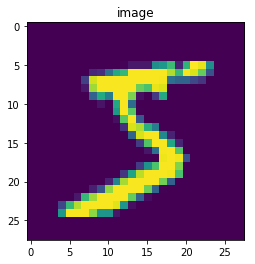

In [10]:
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_reader()):
    # 获得图像数据，并转为float32类型的数组
    img_data = np.array([x[0] for x in data]).astype('float32')
    # 获得图像标签数据，并转为float32类型的数组
    label_data = np.array([x[1] for x in data]).astype('float32')
    # 打印数据形状
    print("图像数据形状和对应数据为:", img_data.shape, img_data[0])
    print("图像标签形状和对应数据为:", label_data.shape, label_data[0])
    break

print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(label_data[0]))
# 显示第一batch的第一个图像
import matplotlib.pyplot as plt
img = np.array(img_data[0]+1)*127.5
img = np.reshape(img, [28, 28]).astype(np.uint8)

plt.figure("Image") # 图像窗口名称
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

从代码的输出来看，我们从数据加载器train_loader()中读取一次数据，可以得到形状为 (8, 784)的图像数据和形状为(8,)的标签数据。其中，8与设置的batch大小对应，784为mnist数据集中每个图像的像素数量(28*28)。

另外，从打印的图像数据来看，图像数据的范围是[-1, 1]，表明这是已经完成图像归一化后的图像数据，且背景部分的值是-1。我们可以将图像数据反归一化，并使用matplotlib工具包将其显示出来。显示的数字是5，和对应标签数字一致。

------
**说明：**

飞桨将维度是28\*28的手写数字数据图像转成向量形式存储，因此，使用飞桨数据读取到的手写数字图像是长度为784（28\*28）的向量。

------

# 2. 模型设计
在“房价预测”深度学习任务中，我们使用了单层且没有非线性变换的模型，取得了理想的预测效果。在“手写数字识别”中，我们依然使用这个模型预测输入的图形数字值。其中，模型的输入为784维（28\*28）数据，输出为1维数据，如**图1**所示。

<center>
<img src="https://ai-studio-static-online.cdn.bcebos.com/80aea55a15ff4da1bb13a661f26cf8d97b19101e30e44c6fa5f5eb723ce5edb3" width="300" hegiht="200"></center>

<center><br>图1：与“房价预测”模型一样的简单网络</br></center>



In [4]:
# 定义mnist数据识别网络结构，同房价预测网络
class MNIST(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(MNIST, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义一层全连接层，输出维度是1，激活函数为None，即不使用激活函数
        self.fc = FC(name_scope, size=1, act=None)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

# 3. 训练配置

训练配置负责神经网络训练前的准备，包括：

1. 声明定义好的模型。
2. 加载训练数据和测试数据。
3. 设置优化算法和学习率，本次实验优化算法使用随机梯度下降SGD，学习率使用 0.01。

In [ ]:
# 定义飞桨动态图工作环境
with fluid.dygraph.guard():
    # 声明网络结构
    model = MNIST("mnist")
    # 启动训练模式
    model.train()
    # 定义数据读取函数，数据读取batch_size设置为16
    train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=16)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)

# 4. 训练过程

完成训练配置后，可启动训练过程。采用二层循环嵌套方式：
- 内层循环负责整个数据集的一次遍历，遍历数据集采用分批次（batch）方式。
- 外层循环定义遍历数据集的次数，本次训练中外层循环10次，通过参数EPOCH_NUM设置。

In [5]:
# 通过with语句创建一个dygraph运行的context，
# 动态图下的一些操作需要在guard下进行
with fluid.dygraph.guard():
    model = MNIST("mnist")
    model.train()
    train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=16)
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，格式需要转换成符合框架要求的
            image_data = np.array([x[0] for x in data]).astype('float32')
            label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
            # 将数据转为飞桨动态图格式
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
            
            #前向计算的过程
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id !=0 and batch_id  % 1000 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'mnist')

epoch: 0, batch: 1000, loss is: [1.8877316]
epoch: 0, batch: 2000, loss is: [3.9273722]
epoch: 0, batch: 3000, loss is: [4.084848]
epoch: 1, batch: 1000, loss is: [1.854464]
epoch: 1, batch: 2000, loss is: [3.8591747]
epoch: 1, batch: 3000, loss is: [3.7979107]
epoch: 2, batch: 1000, loss is: [1.8508763]
epoch: 2, batch: 2000, loss is: [3.8116078]
epoch: 2, batch: 3000, loss is: [3.6144927]
epoch: 3, batch: 1000, loss is: [1.8574097]
epoch: 3, batch: 2000, loss is: [3.790052]
epoch: 3, batch: 3000, loss is: [3.484096]
epoch: 4, batch: 1000, loss is: [1.8664289]
epoch: 4, batch: 2000, loss is: [3.7832546]
epoch: 4, batch: 3000, loss is: [3.385687]
epoch: 5, batch: 1000, loss is: [1.8755915]
epoch: 5, batch: 2000, loss is: [3.7839074]
epoch: 5, batch: 3000, loss is: [3.308744]
epoch: 6, batch: 1000, loss is: [1.8844205]
epoch: 6, batch: 2000, loss is: [3.7880387]
epoch: 6, batch: 3000, loss is: [3.247213]
epoch: 7, batch: 1000, loss is: [1.8928452]
epoch: 7, batch: 2000, loss is: [3.7936

通过观察训练过程中损失所发生的变化，可以发现虽然损失整体上在降低，但到训练的最后一轮，损失函数值依然较高。可以猜测，“手写数字识别”完全复用“房价预测”的代码，训练效果并不好。接下来我们通过模型测试，获取模型训练的真实效果。

# 5. 模型测试


模型测试的主要目的是验证训练好的模型是否能正确识别出数字。测试模型包括以下三步：

- 从'./demo/example_0.jpg'目录下读取样例图片。
- 加载模型并将模型的状态设置为校验状态（eval），显式告诉框架我们接下来只会使用前向计算的流程，不会计算梯度和梯度反向传播，这将减少内存的消耗。
- 将测试样本传入模型，获取预测结果，取整后作为预测标签输出。

1.0 0.0


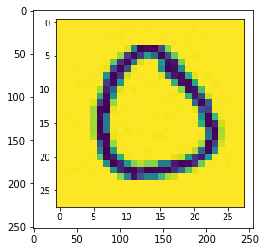

In [14]:
# 导入图像读取第三方库
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# 读取图像
example = mpimg.imread('./work/example_0.png')
# 显示图像
plt.imshow(example)

In [21]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    print(np.array(im))
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, -1).astype(np.float32)
    # 图像归一化，保持和数据集的数据范围一致
    im = 2 - im / 127.5
    return im

# 定义预测过程
with fluid.dygraph.guard():
    model = MNIST("mnist")
    params_file_path = 'mnist'
    img_path = './work/example_0.png'
    # 加载模型参数
    model_dict, _ = fluid.load_dygraph("mnist")
    model.load_dict(model_dict)
    
    model.eval()
    tensor_img = load_image(img_path)
    result = model(fluid.dygraph.to_variable(tensor_img))
    #预测输出取整，即为预测的数字
    print("本次预测的数字是", result.numpy().astype('int32'))

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
本次预测的数字是 [[1]]


如上可见，模型错误预测样例图片中的数字是1，实际应该预测的结果是0。但如果我们尝试更多的样本，会发现很多数字图片识别结果是错误的，完全复用房价预测的实验并不适用于手写数字识别任务，接下来我们会对该实验进行逐一改进，直到获得令人满意的结果。




## 思考题：

1. 使用飞桨API [paddle.dataset.mnist](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/data/dataset_cn.html)的test函数获得测试集数据，计算当前模型的准确率。

2. 怎样进一步提高模型的准确率？对于手写数字识别任务，机械的套用“房价预测”的模型是不行的。接下来，我们将逐一考察模型的每个环节可以做出怎样的优化。